In [1]:
import qiskit as qsk, numpy as np, matplotlib.pyplot as plt
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Resize
from qiskit.quantum_info import SparsePauliOp, Statevector, Clifford, PauliList
from typing import Callable

def random_thetas(shape: "shape"):
    possible_theta_values = np.pi / 2 * np.arange(4)
    # print(possible_theta_values)
    # print(shape)
    return np.random.choice(possible_theta_values, shape)

def evolveSPO(op: SparsePauliOp, other: Clifford) -> SparsePauliOp:
    return SparsePauliOp(
        op.paulis.evolve(other)
    )

def img_to_vec(image: torch.Tensor):
    n = int(np.log2(image.shape[0]))  # Image should be a 2^n x 2^n tensor
    image = image.reshape([2 for i in range(2*n)])  # Convert tensor indices from y,x to y0,y1,...,yn-1,x0,x1,...,xn-1
    image = image.permute([i+j for i in range(n) for j in [0, n]])  # Permute indices from y0,y1,...,yn-1,x0,x1,...,xn-1 to y0,x0,y1,x1,...,yn-1,xn-1
    vec = image.flatten()
    return np.array([x for x in vec])

def sumZ(n_qubits: int) -> SparsePauliOp:
    return SparsePauliOp.from_sparse_list(
        [("Z", [i], 1) for i in range(n_qubits)],
        num_qubits = n_qubits
    )

mnist_train = MNIST("./data",
                    train= True,
                    transform= ToTensor(),
                    download= True)

def get_image(idx: int, dataset, n_qubits: int):
    image, label = dataset[idx]
    size = 2**n_qubits
    padded_image = torch.zeros([size, size])
    padded_image[:28, :28] = image.squeeze()[:, :]
    return padded_image

class ParametricCircuit:
    def __init__(self):
        self.n_parameters: int = None
        self.params_shape: "shape" = None
    
    def __call__(self, thetas: np.ndarray, *args, **kwds) -> qsk.QuantumCircuit:
        pass

class Model:
    def __init__(self,
                 parametric_circuit: ParametricCircuit,
                 encoding: Callable[..., Statevector],
                 observable: SparsePauliOp
                 ):
        self.param_circ = parametric_circuit
        self.enc = encoding
        self.obs = observable
        self.use_inefficient_method: bool = False

    # def inefficient_call(self, thetas: np.ndarray, input) -> float:
    #     psi = self.enc(input)
    #     qc = self.param_circ(thetas)
    #     evolved_psi = psi.evolve(qc)
    #     return evolved_psi.expectation_value(self.obs)

    def __call__(self, thetas: np.ndarray, input) -> float:
        psi = self.enc(input)
        qc = self.param_circ(thetas)
        if self.use_inefficient_method == False:
            evolved_ops = evolveSPO(self.obs, Clifford(qc))
            return psi.expectation_value(evolved_ops)
        else:
            evolved_psi = psi.evolve(qc)
            return evolved_psi.expectation_value(self.obs)
    
    def param_shift_rule_grad(self, thetas: np.ndarray, input, index: tuple[int]) -> float:
        # print(f"Relevant theta = {thetas[index]}")
        thetas[index] += np.pi / 2
        # print(f"Relevant theta = {thetas[index]}")
        value_plus = self.__call__(thetas, input)
        # print(f"Value plus = {value_plus}")
        thetas[index] -= np.pi
        # print(f"Relevant theta = {thetas[index]}")
        value_minus = self.__call__(thetas, input)
        thetas[index] += np.pi/2
        # print(f"Value minus = {value_minus}")
        return (value_plus - value_minus) / 2
    
    def empirical_NTK(self, thetas: np.ndarray, input1, input2) -> float:
        grad = self.param_shift_rule_grad
        # print(
        #     np.array([
        #         self.param_shift_rule_grad(thetas, input1, index) #* grad(thetas, input2, index)
        #         for index in np.ndindex(thetas.shape)
        #     ])
        # )
        return np.sum([
            grad(thetas, input1, index) * grad(thetas, input2, index)
            for index in np.ndindex(thetas.shape)
        ])
    
    def analytic_NTK(self, input1, input2, n_shots):
        return np.mean([
            self.empirical_NTK(random_thetas(self.param_circ.params_shape),
                               input1, input2)
            for _ in range(n_shots)
        ])


class SimpleTestCircuit(ParametricCircuit):
    def __init__(self, n_qubits: int):
        self.n_parameters: int = n_qubits
        self.params_shape: tuple[int] = (n_qubits)
    
    def __call__(self, thetas: np.ndarray) -> qsk.QuantumCircuit:
        qc = qsk.QuantumCircuit(self.n_parameters)
        for i in range(self.n_parameters): qc.rx(thetas[i], i)
        return qc

class ConvolutionalQNN(ParametricCircuit):
    def __init__(self, n_qubits: int, n_layers: int):
        self.qc: qsk.QuantumCircuit = None
        self.n_qubits: int = n_qubits
        self.n_layers: int = n_layers
        self.params_shape: tuple[int] = (4, 5*n_qubits//2 - 4, n_layers)
        self.n_parameters: int = np.prod(self.params_shape)

    def elementary_2_qubit_gate(self, thetas: np.ndarray, qubit1: int, qubit2: int):
        self.qc.rx(thetas[0], qubit1)
        self.qc.rx(thetas[1], qubit2)
        self.qc.cx(qubit1, qubit2)
        self.qc.rz(thetas[2], qubit1)
        self.qc.rz(thetas[3], qubit2)
    
    def layer(self, thetas: np.ndarray):
        i = 0
        def apply_gate(qubit1: int, qubit2: int):
            nonlocal i
            self.elementary_2_qubit_gate(thetas[:, i], qubit1, qubit2)
            i += 1
        
        def xiyi_gates(central_qubit: int):
            if central_qubit>0: apply_gate(central_qubit-2, central_qubit-1)
            apply_gate(central_qubit, central_qubit+1)
            if central_qubit<self.n_qubits-2: apply_gate(central_qubit+2, central_qubit+3)
        
        def xxyy_gates(lower_qubit: int):
            apply_gate(lower_qubit, lower_qubit+2)
            apply_gate(lower_qubit+1, lower_qubit+3)
        
        for qubit in np.arange(0, self.n_qubits-2, 2):
            xiyi_gates(qubit)
            xxyy_gates(qubit)
        xiyi_gates(self.n_qubits-2)
    
    def __call__(self, thetas):
        self.qc = qsk.QuantumCircuit(self.n_qubits)
        for i in range(self.n_layers):
            self.layer(thetas[:,:,i])
            self.qc.barrier()
        return self.qc


['n: 10, time = 0.0032049138940001285\n', 'n: 12, time = 0.004002430242000628\n', 'n: 14, time = 0.00492592059799972\n']


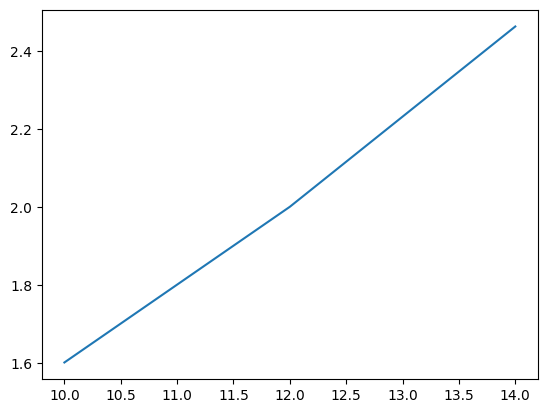

In [27]:
# Testing time cost of Clifford(qc)
from timeit import default_timer as timer

np.random.seed(42)

times=[]
ns = [10,12,14]
for n_qubits in ns:
    n_qubits
    n_layers = 1

    parametric_qnn = ConvolutionalQNN(n_qubits, n_layers)
    qc = parametric_qnn(random_thetas(parametric_qnn.params_shape))
    start_time = timer()
    n_shots = 500
    for _ in range(n_shots): clifford_qc = Clifford(qc)
    end_time = timer()
    times.append(end_time - start_time)

plt.plot(ns, times)
print([
    f"n: {ns[i]}, time = {times[i] / n_shots}\n" for i in range(len(ns))
])

For n = 10
            op = sumZ(n) takes 0.0002947080001831637
            Building psi takes 0.005753942999945139
            Computing the result 5000 times takes 0.00012016104700014694 on average
For n = 12
            op = sumZ(n) takes 0.0003552529997250531
            Building psi takes 0.008720243000425398
            Computing the result 5000 times takes 0.00017510414959997434 on average


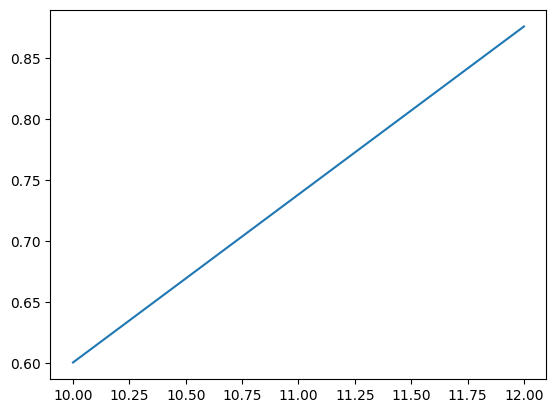


Notice that for n = 10, the build time is 0.00483s. However, in the current version of the code,
psi is independently built 4 * N_gates = 1008 times each time we compute an
empirical NTK, leading to a 4s time loss.

Computing the final scalar product 1000 times still takes 0.1s, so
the whole experiment on the 60k-sized MNIST would take ~4000d: it's still too slow.



In [25]:
# Testing time cost of final product

times = []
ns = [10, 12]
for n in ns:
    time0 = timer()
    op = sumZ(n)
    time1 = timer()
    vec = img_to_vec(
        get_image(
            0, mnist_train, n//2
        )
    )
    psi = Statevector(vec)
    time2 = timer()
    start_time = timer()
    n_shots = 5000
    for _ in range(n_shots):
        result = psi.expectation_value(op)
    end_time = timer()
    times.append(end_time - start_time)
    print(f"For n = {n}\n\
            op = sumZ(n) takes {time1 - time0}\n\
            Building psi takes {time2 - time1}\n\
            Computing the result {n_shots} times takes {(end_time-start_time)/n_shots} on average")

plt.plot(ns, times)
plt.show()

print("""
Notice that for n = 10, the build time is 0.00483s. However, in the current version of the code,
psi is independently built 4 * N_gates = 1008 times each time we compute an
empirical NTK, leading to a 4s time loss.

Computing the final scalar product 1000 times still takes 0.1s, so
the whole experiment on the 60k-sized MNIST would take ~4000d: it's still too slow.
""")

For n = 10
            op = sumZ(n) takes 0.000242629000240413
            Building psi takes 0.006744184999661229
            Computing the result 10000 times takes 0.00010043350839996493 on average
For n = 12
            op = sumZ(n) takes 0.00014843099961581174
            Building psi takes 0.008154396000463748
            Computing the result 10000 times takes 0.0001277395365999837 on average
For n = 14
            op = sumZ(n) takes 0.0001433809993613977
            Building psi takes 0.03454560699992726
            Computing the result 10000 times takes 0.0002506436865000069 on average
For n = 16
            op = sumZ(n) takes 0.0001441530002921354
            Building psi takes 0.309621037999932
            Computing the result 10000 times takes 0.0007263232809000328 on average
For n = 18
            op = sumZ(n) takes 0.00014490499961539172
            Building psi takes 0.944703121999737
            Computing the result 10000 times takes 0.002751340689800054 on average


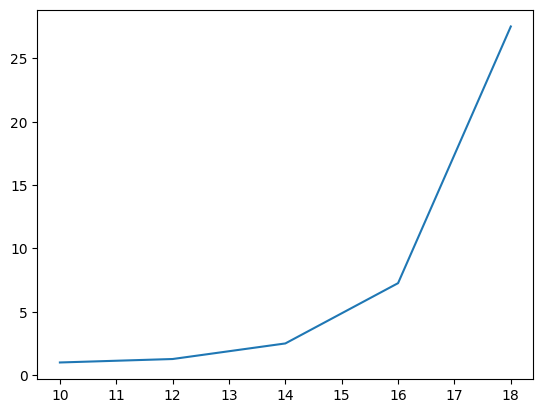

In [ ]:
# Testing time cost of final product,
# representing the operator as a Pauli list instead of a SparsePauliOp

def char(i,j):
    return "Z" if i==j else "I"

times = []
ns = [10, 12, 14, 16]
for n in ns:
    time0 = timer()
    op = PauliList([
                ''.join([char(i, j) for i in range(10)]) for j in range(10)
            ])
    time1 = timer()
    vec = img_to_vec(
        get_image(
            0, mnist_train, n//2
        )
    )
    psi = Statevector(vec)
    time2 = timer()
    start_time = timer()
    n_shots = 10_000
    for _ in range(n_shots):
        result = np.sum([
            psi._expectation_value_pauli(op[i]) for i in range(len(op))
        ])
    
    end_time = timer()
    times.append(end_time - start_time)
    print(f"For n = {n}\n\
            op = sumZ(n) takes {time1 - time0}\n\
            Building psi takes {time2 - time1}\n\
            Computing the result {n_shots} times takes {(end_time-start_time)/n_shots} on average")

plt.plot(ns, times)
plt.show()